In [1]:
%matplotlib inline

1. Predict with pre-trained Mask RCNN models
===============================================

This article shows how to play with pre-trained Mask RCNN model.

Mask RCNN networks are extensions to Faster RCNN networks.
:py:class:`gluoncv.model_zoo.MaskRCNN` is inherited from
:py:class:`gluoncv.model_zoo.FasterRCNN`.
It is highly recommended to read :doc:`../examples_detection/demo_faster_rcnn` first.

First let's import some necessary libraries:



In [2]:
from matplotlib import pyplot as plt
from gluoncv import model_zoo, data, utils
import mxnet as mx

In [20]:
class DrivableMapsAccMetric(mx.metric.EvalMetric):
    def __init__(self):
        super(DrivableMapsAccMetric, self).__init__('DrivableMapsAcc')
    
    def update(self, labels, preds):
        # label = [label, weight]
        # pred = [rcnn_mask]
        # label = labels[0].asnumpy()
        # pred = preds[0].asnumpy()
        
        # pixel_labeled = np.sum(label > 0)
        # pixel_correct = np.sum((pred == label)*(label > 0))
        # pixel_accuracy = 1.0 * pixel_correct / pixel_labeled
        # print(pixel_accuracy)
        # print('pixel_labeled', labels[0].shape)# (1, 3, 180, 320)
        label, weight = labels
        label = label.sum(axis=1) > 1.5
        pred = preds[0].sum(axis=1) >= 1.5

        # calculate num_inst
        num_inst = mx.nd.array([1])
        # print('label', label.shape,'pred',pred.shape)
        # print('label', label ,'pred', pred)
        pixel_labeled = mx.nd.sum(label > 0)
        # print('pixel_labeled', pixel_labeled)
        pixel_pred = mx.nd.sum(pred > 0)   
        # print('pixel_pred', pixel_pred)
        pixel_correct = mx.nd.sum((pred == label)*(label > 0))
        # print('pixel_correct', pixel_correct)
        pixel_accuracy = 1.0 * pixel_correct / (pixel_labeled + 0.000001)
        # print('pixel_accuracy', pixel_accuracy)
        # if not (niter+1) % 100:
        #     print(pixel_accuracy)
        self.sum_metric += pixel_accuracy.asscalar()
        self.num_inst += num_inst.asscalar()
 
x = mx.nd.random.uniform(-1, 1,(1,3,180, 320))
y = mx.nd.random.uniform(-1, 1,(1,3,180, 320))
x = mx.nd.ones((1, 3, 4, 4))
y = mx.nd.ones((1, 3, 4, 4))
a = mx.nd.zeros((1,3,4,4))
me = DrivableMapsAccMetric()
me.update([x,x],[y])
me.sum_metric

0.9999998807907104

In [13]:
z = mx.nd.random.uniform(-1, 1,(1, 3, 4, 4))

In [21]:
a


[[[[0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]]

  [[0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]]

  [[0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]]]]
<NDArray 1x3x4x4 @cpu(0)>

In [16]:
mx.nd.softmax(z, axis=1)


[[[[0.14474821 0.55530435 0.22574969 0.30828744]
   [0.19000122 0.42234102 0.11651628 0.46693927]
   [0.32045847 0.1617809  0.56574184 0.44147626]
   [0.15128948 0.36804342 0.5359332  0.5451148 ]]

  [[0.49886727 0.21704751 0.6606845  0.36699447]
   [0.33854786 0.369413   0.39047575 0.37222323]
   [0.26330537 0.58760154 0.18169959 0.26366255]
   [0.6917033  0.10748935 0.20068192 0.20479998]]

  [[0.35638452 0.22764817 0.11356576 0.32471803]
   [0.4714509  0.20824605 0.49300787 0.1608375 ]
   [0.41623616 0.2506176  0.2525586  0.29486123]
   [0.15700716 0.52446723 0.26338488 0.25008523]]]]
<NDArray 1x3x4x4 @cpu(0)>

In [24]:
a[0,2,:,:]=3
a


[[[[1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]]

  [[2. 2. 2. 2.]
   [2. 2. 2. 2.]
   [2. 2. 2. 2.]
   [2. 2. 2. 2.]]

  [[3. 3. 3. 3.]
   [3. 3. 3. 3.]
   [3. 3. 3. 3.]
   [3. 3. 3. 3.]]]]
<NDArray 1x3x4x4 @cpu(0)>

In [53]:
me.update([x],[y],99)
me.sum_metric

label (1, 180, 320) pred (1, 180, 320)
pixel_labeled 
[57600.]
<NDArray 1 @cpu(0)>
pixel_correct 
[57600.]
<NDArray 1 @cpu(0)>

[1.001]
<NDArray 1 @cpu(0)>


1.0010000467300415

In [28]:
a,b,c = mx.nd.split(a, axis=1, num_outputs=3)
a = a==1
b = b==2
c = c==3
mx.nd.concat(a,b,c,dim=1)


[[[[1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]]

  [[1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]]

  [[1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]]]]
<NDArray 1x3x4x4 @cpu(0)>

Load a pretrained model
-------------------------

Let's get an Mask RCNN model trained on COCO dataset with ResNet-50 backbone.
By specifying ``pretrained=True``, it will automatically download the model
from the model zoo if necessary. For more pretrained models, please refer to
:doc:`../../model_zoo/index`.

The returned model is a HybridBlock :py:class:`gluoncv.model_zoo.MaskRCNN`
with a default context of `cpu(0)`.



In [57]:
net = model_zoo.get_model('mask_rcnn_resnet50_v1b_coco', pretrained=True, root='/Volumes/DATASET/mxnet')

full_name mask_rcnn_resnet50_v1b_coco


MXNetError: [23:38:17] src/io/local_filesys.cc:199: Check failed: allow_null  LocalFileSystem::Open "/Volumes/DATASET/mxnet/mask_rcnn_resnet50_v1b_coco.params": No such file or directory

Stack trace returned 8 entries:
[bt] (0) 0   libmxnet.so                         0x000000010f9a2c90 libmxnet.so + 15504
[bt] (1) 1   libmxnet.so                         0x000000010f9a2a3f libmxnet.so + 14911
[bt] (2) 2   libmxnet.so                         0x000000010f9a2669 libmxnet.so + 13929
[bt] (3) 3   libmxnet.so                         0x00000001114d1ac0 MXTVMBridge + 4812816
[bt] (4) 4   libmxnet.so                         0x00000001114cad64 MXTVMBridge + 4784820
[bt] (5) 5   libmxnet.so                         0x0000000110e3a903 MXNDArrayLoad + 227
[bt] (6) 6   _ctypes.cpython-35m-darwin.so       0x000000010d5c2577 ffi_call_unix64 + 79
[bt] (7) 7   Python                              0x00007fff5bff88f0 Python + 140730441894128



Pre-process an image
--------------------

The pre-processing step is identical to Faster RCNN.

Next we download an image, and pre-process with preset data transforms.
The default behavior is to resize the short edge of the image to 600px.
But you can feed an arbitrarily sized image.

You can provide a list of image file names, such as ``[im_fname1, im_fname2,
...]`` to :py:func:`gluoncv.data.transforms.presets.rcnn.load_test` if you
want to load multiple image together.

This function returns two results. The first is a NDArray with shape
`(batch_size, RGB_channels, height, width)`. It can be fed into the
model directly. The second one contains the images in numpy format to
easy to be plotted. Since we only loaded a single image, the first dimension
of `x` is 1.

Please beware that `orig_img` is resized to short edge 600px.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


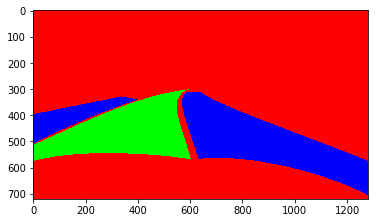

In [71]:
# im_fname = utils.download('https://github.com/dmlc/web-data/blob/master/' +
#                           'gluoncv/detection/biking.jpg?raw=true',
#                           path='biking.jpg')
# x, orig_img = data.transforms.presets.rcnn.load_test('b1c81faa-c80764c5_drivable_id.png')
x = mx.image.imread('b1c81faa-c80764c5_drivable_id.png')
# print(net(x))
import mxnet as mx
import numpy as np
# x.shape

a,b,c = mx.nd.split(x, axis=2, num_outputs=3)
a = a==0.
b = b==1.
c = c==2.
x = mx.nd.concat(a,b,c,dim=2).astype(np.float32)

plt.imshow(x.asnumpy()*255)
plt.show()

In [74]:
s = mx.nd.softmax(x, axis=2)
s


[[[0.5761169  0.21194157 0.21194157]
  [0.5761169  0.21194157 0.21194157]
  [0.5761169  0.21194157 0.21194157]
  ...
  [0.5761169  0.21194157 0.21194157]
  [0.5761169  0.21194157 0.21194157]
  [0.5761169  0.21194157 0.21194157]]

 [[0.5761169  0.21194157 0.21194157]
  [0.5761169  0.21194157 0.21194157]
  [0.5761169  0.21194157 0.21194157]
  ...
  [0.5761169  0.21194157 0.21194157]
  [0.5761169  0.21194157 0.21194157]
  [0.5761169  0.21194157 0.21194157]]

 [[0.5761169  0.21194157 0.21194157]
  [0.5761169  0.21194157 0.21194157]
  [0.5761169  0.21194157 0.21194157]
  ...
  [0.5761169  0.21194157 0.21194157]
  [0.5761169  0.21194157 0.21194157]
  [0.5761169  0.21194157 0.21194157]]

 ...

 [[0.5761169  0.21194157 0.21194157]
  [0.5761169  0.21194157 0.21194157]
  [0.5761169  0.21194157 0.21194157]
  ...
  [0.5761169  0.21194157 0.21194157]
  [0.5761169  0.21194157 0.21194157]
  [0.5761169  0.21194157 0.21194157]]

 [[0.5761169  0.21194157 0.21194157]
  [0.5761169  0.21194157 0.21194157]

Inference and display
---------------------

The Mask RCNN model returns predicted class IDs, confidence scores,
bounding boxes coordinates and segmentation masks.
Their shape are (batch_size, num_bboxes, 1), (batch_size, num_bboxes, 1)
(batch_size, num_bboxes, 4), and (batch_size, num_bboxes, mask_size, mask_size)
respectively. For the model used in this tutorial, mask_size is 14.

Object Detection results

We can use :py:func:`gluoncv.utils.viz.plot_bbox` to visualize the
results. We slice the results for the first image and feed them into `plot_bbox`:

Plot Segmentation

:py:func:`gluoncv.utils.viz.expand_mask` will resize the segmentation mask
and fill the bounding box size in the original image.
:py:func:`gluoncv.utils.viz.plot_mask` will modify an image to
overlay segmentation masks.



In [59]:
ids, scores, bboxes, masks = [xx[0].asnumpy() for xx in net(x)]

# paint segmentation mask on images directly
width, height = orig_img.shape[1], orig_img.shape[0]
masks = utils.viz.expand_mask(masks, bboxes, (width, height), scores)
orig_img = utils.viz.plot_mask(orig_img, masks)

# identical to Faster RCNN object detection
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax = utils.viz.plot_bbox(orig_img, bboxes, scores, ids,
                         class_names=net.classes, ax=ax)
plt.show()

NameError: name 'net' is not defined

In [26]:
net = model_zoo.get_model('faster_rcnn_resnet50_v1b_coco', pretrained=True, root='/Volumes/DATASET/mxnet')

Model file is not found. Downloading.



  9%|▉         | 11475/123821 [00:37<06:08, 305.19KB/s]


 30%|███       | 37587/123821 [01:19<03:02, 471.41KB/s]


 35%|███▍      | 42803/123821 [02:14<04:14, 318.00KB/s]


 39%|███▉      | 48531/123821 [02:59<04:38, 270.61KB/s]


 44%|████▍     | 55091/123821 [03:45<04:40, 244.78KB/s]


 50%|█████     | 62387/123821 [04:29<04:25, 231.38KB/s]


 60%|██████    | 74435/123821 [05:08<03:24, 240.91KB/s]


 66%|██████▌   | 81603/123821 [05:51<03:02, 231.86KB/s]


 76%|███████▌  | 94307/123821 [06:31<02:02, 240.59KB/s]


 83%|████████▎ | 103191/123821 [07:16<01:27, 236.59KB/s]


 91%|█████████▏| 113267/123821 [07:58<00:44, 236.83KB/s]


 97%|█████████▋| 120307/123821 [08:42<00:15, 230.47KB/s]


100%|█████████▉| 123779/123821 [08:52<00:00, 232.56KB/s]
123822KB [08:52, 232.60KB/s]                            

error: Error -3 while decompressing data: invalid block type

In [27]:
import mxnet as mx

In [51]:
model = mx.ndarray.load('/Volumes/DATASET/mxnet/mask_rcnn_resnet50_v1b_coco-a3527fdc.params')

In [52]:
model.keys()

dict_keys(['features.4.1.bn2.gamma', 'features.6.1.bn3.gamma', 'top_features.0.1.conv3.weight', 'features.6.3.conv3.weight', 'features.6.4.conv3.weight', 'top_features.0.0.downsample.1.beta', 'features.6.0.bn2.gamma', 'features.6.1.conv3.weight', 'top_features.0.2.bn1.running_mean', 'top_features.0.2.bn2.running_mean', 'features.6.3.bn1.beta', 'features.5.2.bn3.running_mean', 'features.5.1.bn2.beta', 'features.4.1.bn3.running_var', 'features.6.0.downsample.1.running_mean', 'features.6.0.conv2.weight', 'features.4.1.bn1.running_var', 'features.4.1.conv1.weight', 'features.6.4.bn2.beta', 'features.4.1.bn2.beta', 'top_features.0.0.bn2.beta', 'features.4.0.bn3.running_var', 'features.6.3.bn1.running_mean', 'features.6.4.bn2.running_mean', 'features.5.0.downsample.1.running_mean', 'features.4.2.bn1.running_var', 'features.5.3.bn1.gamma', 'features.5.1.bn3.gamma', 'mask.deconv.weight', 'features.4.0.bn3.beta', 'features.5.0.bn3.gamma', 'features.5.1.bn1.beta', 'top_features.0.1.bn1.running_v

In [ ]:
model = mx.ndarray.load('/Volumes/DATASET/mxnet/mask_rcnn_resnet50_v1b_coco-a3527fdc.params')

In [115]:
model = mx.ndarray.load('/home/user/.mxnet/models/mask_rcnn_resnet50_v1b_coco-a3527fdc.params')
model_new = model.copy()
cls_names = ['class_predictor.bias', 'class_predictor.weight']
box_names = ['box_predictor.bias', 'box_predictor.weight']

inds = [0,10,12,1,1,2,6,3,4,7,8]
cls_index = mx.nd.array(inds).reshape(-1)
box_index = mx.nd.array([(i*4,i*4+1,i*4+2,i*4+3) for i in inds[1:]]).reshape(-1)
for s in cls_names:
    model_new[s] = mx.ndarray.take(model_new[s], cls_index)
    print(model_new[s].shape, model[s].shape)
    model_new[s][4] = model_new[s][4]*0.9
    
for s in box_names:
    model_new[s] = mx.ndarray.take(model_new[s], box_index)
    print(model_new[s].shape, model[s].shape)
mx.ndarray.save('/Volumes/DATASET/mxnet/mask_rcnn_resnet50_v1b_coco.params', model_new)

(11,) (81,)
(11, 2048) (81, 2048)
(40,) (320,)
(40, 2048) (320, 2048)


In [116]:
mx.ndarray.save('/Volumes/DATASET/mxnet/mask_rcnn_resnet50_v1b_coco.params', model_new)

In [114]:
model['class_predictor.weight'][1]


[ 0.0682077  -0.0477075  -0.00805354 ... -0.03167785  0.04776628
  0.07690672]
<NDArray 2048 @cpu(0)>

In [101]:
bias = model['class_predictor.bias']
print(bias[1])

b = mx.nd.zeros((11), dtype=bias.dtype)
index = [0,10,12,1,1,2,6,3,4,7,8]
# bias = bias.asnumpy()
# for i in range(81):
#     if i not in index:
#         np.delete(bias, i)
# print(bias)
mx.ndarray.take(bias,mx.nd.array(index))


[0.15823478]
<NDArray 1 @cpu(0)>



[ 0.78373694 -0.00105482 -0.02424904  0.15823478  0.15823478 -0.00568883
 -0.01327221  0.04353329 -0.00437014  0.02157271 -0.01940714]
<NDArray 11 @cpu(0)>

In [46]:
b[0] = model['class_predictor.bias']

In [97]:
box_b = model['box_predictor.weight']
box_b


[[-1.0752334e-03  1.5095880e-03  2.4079531e-02 ...  9.2855999e-03
   1.0044650e-03 -4.2596888e-03]
 [ 7.8298047e-04  2.5143739e-02  3.5643209e-02 ... -7.5865993e-03
   1.1896892e-02 -7.3878269e-04]
 [ 9.3359863e-03  1.8783251e-03  6.8476604e-04 ... -2.1145184e-02
   4.5427661e-03 -7.9241628e-03]
 ...
 [-1.6420951e-02 -1.2419077e-02  1.9063624e-02 ... -2.9928142e-03
  -1.7363789e-04 -2.7496166e-05]
 [ 6.2018810e-03  1.6897293e-02 -3.7430804e-03 ... -3.7391854e-03
  -1.1517959e-02 -1.9001040e-04]
 [ 1.4383033e-02  5.8452752e-03 -1.1257570e-02 ... -8.1804243e-04
  -1.0122412e-04  4.6093881e-04]]
<NDArray 320x2048 @cpu(0)>

In [98]:
index2 = [(i*4,i*4+1,i*4+2,i*4+3) for i in [10,12,1,1,2,6,3,4,7,8]]
mx.ndarray.take(box_b, mx.nd.array(index2).reshape(-1))


[[ 0.00010647 -0.0026323   0.01358162 ... -0.00460071  0.00025928
   0.00318974]
 [-0.01348257  0.00310317  0.01737668 ... -0.0145942   0.00268965
   0.00165568]
 [-0.001022    0.00267969  0.00319259 ... -0.01293702 -0.00930176
  -0.00098844]
 ...
 [-0.02931271 -0.0122727   0.01446584 ... -0.01163947 -0.00027858
   0.00921906]
 [ 0.00321957  0.00017235 -0.0075331  ... -0.01252867  0.00728252
   0.00763254]
 [ 0.01350691  0.01289813 -0.01347607 ...  0.00529972  0.00021927
   0.00937998]]
<NDArray 40x2048 @cpu(0)>

In [54]:

from gluoncv.data import BDDInstance
# typically we use train2017 (i.e. train2014 + minival35k) split as training data
# COCO dataset actually has images without any objects annotated,
# which must be skipped during training to prevent empty labels
train_dataset = BDDInstance(root='/Volumes/DATASET/BDD100k/bdd100k/', splits='bdd100k_to_coco_labels_images_val2018', skip_empty=True, use_color_maps=False)
# and val2014 (i.e. minival5k) test as validation data/data1/datasets/bdd100k/
val_dataset = BDDInstance(root='/Volumes/DATASET/BDD100k/bdd100k/', splits='bdd100k_to_coco_labels_images_val2018', skip_empty=False, use_color_maps=False)

print('Training images:', len(train_dataset))
# print('Validation images:', len(val_dataset))


OSError: /Volumes/DATASET/BDD100k/bdd100k/ is not a valid dir. Did you forget to initalize                          datasets described in:                          `http://gluon-cv.mxnet.io/build/examples_datasets/index.html`?                          You need to initialize each dataset only once.

In [61]:
# We can read an (image, label, segm) tuple from the training dataset:
train_image, train_label, train_segm = train_dataset[1]
bboxes = train_label[:, :4]
cids = train_label[:, 4:5]
print('image:', train_image.shape)
print('bboxes:', bboxes.shape, 'class ids:', cids.shape)
print('drivable_map:', train_segm.shape)

image: (720, 1280, 3)
bboxes: (4, 4) class ids: (4, 1)
drivable_map: (720, 1280, 3)


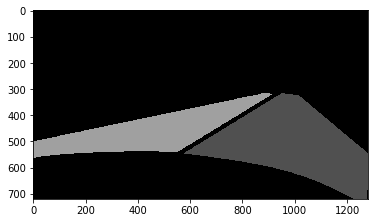

In [62]:
from matplotlib import pyplot as plt
from gluoncv.utils import viz
plt.imshow(train_segm.asnumpy()* 80)
# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(1, 1, 1)
# ax = viz.plot_bbox(train_segm, bboxes, labels=cids, class_names=train_dataset.classes, ax=ax)
plt.show()

In [63]:
from gluoncv.data.transforms import presets
from gluoncv import utils
from mxnet import nd

In [100]:
short, max_size = 500, 720  # resize image to short side 600 px, but keep maximum length within 1000
train_transform = presets.rcnn.BDDMaskRCNNDefaultTrainTransform(short, max_size)
val_transform = presets.rcnn.BDDMaskRCNNDefaultValTransform(short, max_size)

In [101]:
train_image2, train_label2, train_masks2 = train_transform(train_image, train_label, train_segm)
print('tensor shape:', train_image2.shape)
print('box and id shape:', train_label2.shape)
print('drivable map shape', train_masks2.shape)

tensor shape: (3, 405, 720)
box and id shape: (4, 5)
drivable map shape (3, 101, 180)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]]


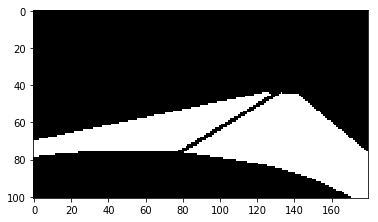

In [111]:
plt.imshow(train_masks2.asnumpy().transpose(1,2,0)* 255)
# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(1, 1, 1)
print(train_masks2.asnumpy().transpose(1,2,0)* 255)
# ax = viz.plot_bbox(train_segm, bboxes, labels=cids, class_names=train_dataset.classes, ax=ax)
plt.show()

In [68]:
from gluoncv.data.batchify import Tuple, Append
from mxnet.gluon.data import DataLoader

batch_size = 2  # for tutorial, we use smaller batch-size
num_workers = 0  # you can make it larger(if your CPU has more cores) to accelerate data loading

train_bfn = Tuple(*[Append() for _ in range(3)])
train_loader = DataLoader(train_dataset.transform(train_transform), batch_size, shuffle=True,
                          batchify_fn=train_bfn, last_batch='rollover', num_workers=num_workers)
val_bfn = Tuple(*[Append() for _ in range(2)])
val_loader = DataLoader(val_dataset.transform(val_transform), batch_size, shuffle=False,
                        batchify_fn=val_bfn, last_batch='keep', num_workers=num_workers)

In [74]:
net = model_zoo.get_model('mask_rcnn_resnet50_v1b_coco', pretrained=False)
net.initialize()

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/mxnet/gluon/block.py:421: UserWarning: load_params is deprecated. Please use load_parameters.
  warnings.warn("load_params is deprecated. Please use load_parameters.")
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/mxnet/gluon/parameter.py:811: UserWarning: Parameter 'resnetv1b4_conv0_weight' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/mxnet/gluon/parameter.py:811: UserWarning: Parameter 'resnetv1b4_batchnorm0_gamma' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/mxnet/gluon/parameter.py:811: UserWarning: Parameter 'resnetv1b4_batchnorm0_beta' is already

In [95]:
# We also push RPN targets computation to CPU workers, so network is passed to transforms
train_transform = presets.rcnn.BDDMaskRCNNDefaultTrainTransform(short, max_size, net)
# return images, labels, masks, rpn_cls_targets, rpn_box_targets, rpn_box_masks loosely
batchify_fn = Tuple(*[Append() for _ in range(6)])
# For the next part, we only use batch size 1
batch_size = 1

train_loader = DataLoader(train_dataset.transform(train_transform), batch_size, shuffle=True,
                          batchify_fn=batchify_fn, last_batch='rollover', num_workers=num_workers)

In [96]:
train_image2, train_label2, train_masks2, rpn_cls_targets, rpn_box_targets, rpn_box_masks = train_transform(train_image, train_label, train_segm)

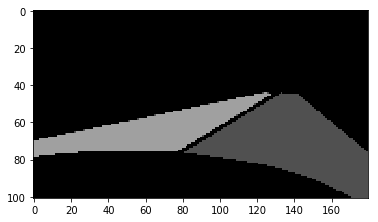

In [97]:
plt.imshow(train_masks2.asnumpy().transpose(1,2,0)* 80)
# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(1, 1, 1)
# ax = viz.plot_bbox(train_segm, bboxes, labels=cids, class_names=train_dataset.classes, ax=ax)
plt.show()


[[[[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   ...
   [0.         0.         0.         ... 0.00392157 0.00392157
    0.00392157]
   [0.         0.         0.         ... 0.00392157 0.00392157
    0.00392157]
   [0.         0.         0.         ... 0.         0.
    0.00392157]]

  [[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   ...
   [0.         0.         0.         ... 0.00392157 0.00392157
    0.00392157]
   [0.         0.         0.         ... 0.00392157 0.00392157
    0.00392157]
   [0.         0.         0.         ... 0.         0.
    0.00392157]]

  [[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         

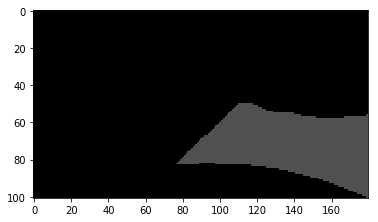

In [99]:
for ib, batch in enumerate(train_loader):
    if ib > 0:
        break
   
    for data, label, drivable_maps, rpn_cls_targets, rpn_box_targets, rpn_box_masks in zip(*batch):
        print(drivable_maps)
        plt.imshow(drivable_maps[0].asnumpy().transpose(1,2,0)* 80)
        # fig = plt.figure(figsize=(10, 10))
        # ax = fig.add_subplot(1, 1, 1)
        # ax = viz.plot_bbox(train_segm, bboxes, labels=cids, class_names=train_dataset.classes, ax=ax)
        plt.show()